# How to visualize pizza-cutter meds files

In [11]:
import fitsio as fio
import numpy as np
import proplot as pplt
from matplotlib import pyplot as plt
import meds
import glob
import matplotlib.patches as patches
import ngmix.medsreaders
import ngmix
%matplotlib inline

In [9]:
meds_fname = '/global/cscratch1/sd/myamamot/des-y6-analysis/data/DES2356-3706_r5992p01_g_pizza-cutter-slices.fits.fz'
# m = meds.MEDS(meds_fname)

In [12]:
mlist = ngmix.medsreaders.NGMixMEDS(meds_fname)

In [33]:
slice_id = 0
# im = m.get_cutout(slice_id, 0)
im_ = mlist.get_obs(slice_id,0).image
im_psf = mlist.get_psf_obs(slice_id,0).image

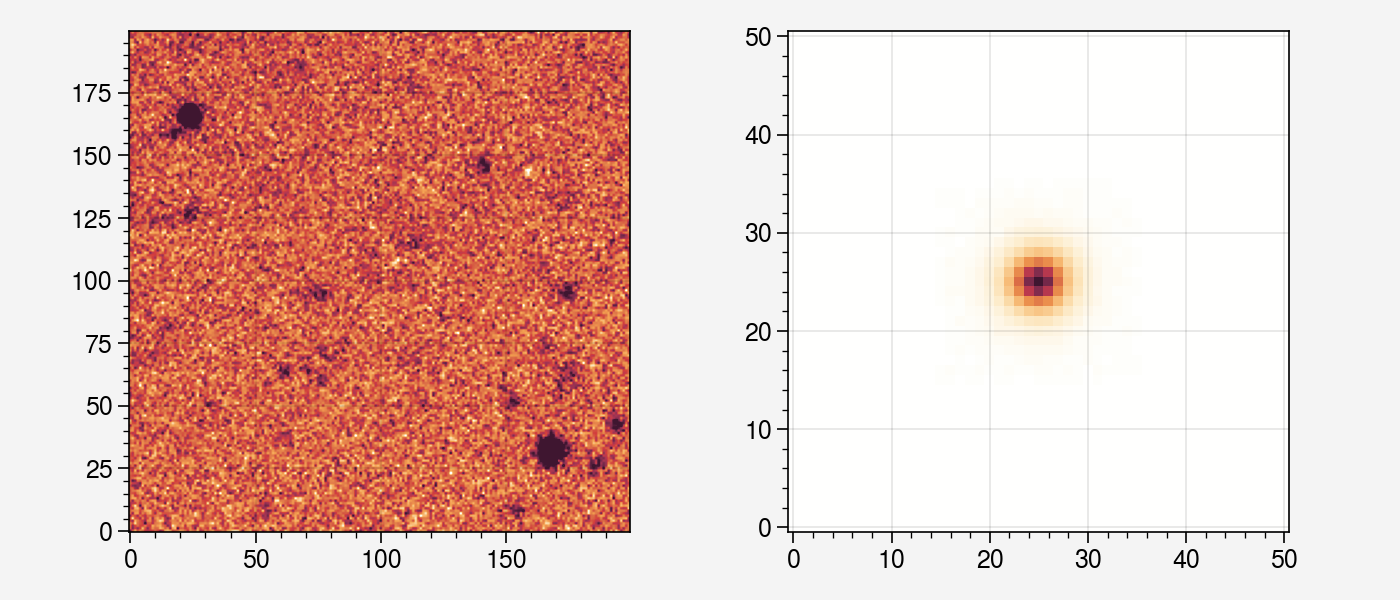

In [34]:
from astropy.visualization import LinearStretch, LogStretch
from astropy.visualization import ZScaleInterval, MinMaxInterval
from astropy.visualization import ImageNormalize
from astropy.io.fits import getdata


fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
norm = ImageNormalize(im_, interval=ZScaleInterval(), stretch=LinearStretch())
ax[0].imshow(im_, origin='lower', norm=norm)
ax[1].imshow(im_psf, origin='lower')

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()

# How to visualize the metadetection object from the slice_id
-> check metadetect_viz.ipynb and /global/cscratch1/sd/myamamot/des-y6-analysis/metadetect_viz.py

# How to apply ngmix on a galsim image

## Make galsim object (image)

In [ ]:
import galsim
# b = galsim.BoundsI(1,51,1,51)
# gal_stamp = galsim.Image(b)
gal = galsim.Exponential(flux=10**(0.4*(30.0-18.0)), half_light_radius=0.5)
psf = galsim.Gaussian(flux=1.0, sigma=1.0)

gal_image = gal.drawImage(scale=0.26)
psf_image = psf.drawImage(scale=0.26)
print(gal_image.array.shape)
print(psf_image.array.shape)

In [ ]:
from matplotlib.colors import LogNorm

ax[0].imshow(gal_image.array, norm=LogNorm())
ax[1].imshow(psf_image.array, norm=LogNorm())

In [ ]:
new_gal = galsim.Convolve([gal, psf])
new_gal_image = new_gal.drawImage(scale=0.26)
new_gal_image.array.shape

## shape measurement with ngmix

### Tips
1. use tab-completion to see what kind of functions are there.
2. use ? to see the docstring (e.g., ngmix.Observation?)

In [1]:
import ngmix

In [3]:
ngmix.Observation?

Init signature:
ngmix.Observation(
    image,
    weight=None,
    bmask=None,
    ormask=None,
    noise=None,
    jacobian=None,
    gmix=None,
    psf=None,
    meta=None,
    mfrac=None,
    store_pixels=True,
    ignore_zero_weight=True,
)
Docstring:     
Represent an observation with an image and possibly a
weight map and jacobian

parameters
----------
image: ndarray
    The image
weight: ndarray, optional
    Weight map, same shape as image
bmask: ndarray, optional
    A bitmask array
ormask: ndarray, optional
    A bitmask array
noise: ndarray, optional
    A noise field to associate with this observation
jacobian: Jacobian, optional
    Type Jacobian or a sub-type
gmix: GMix, optional
    Optional GMix object associated with this observation
psf: Observation, optional
    Optional psf Observation
meta: dict
    Optional dictionary
mfrac: ndarray, optional
    A masked fraction image for this observation.
ignore_zero_weight: bool
    If True, do not store zero weight pixels in

In [ ]:
jac = ngmix.DiagonalJacobian(0.26, row=25.5, col=25.5)
psf_jac = ngmix.DiagonalJacobian(0.26, row=23.5, col=23.5)
wgt = np.ones_like(new_gal_image.array)
psf_wgt = np.ones_like(psf_image.array)
obs_psf =  ngmix.Observation(psf_image.array, weight=psf_wgt, jacobian=psf_jac)

In [ ]:
# make observation object
obs = ngmix.Observation(new_gal_image.array, weight=wgt, psf=obs_psf, jacobian=jac)

In [ ]:
# For pre-PSF moments. 
fitter = ngmix.prepsfmom.PGaussMom(2.0)
# For post-PSF weighted moments. 
# fitter = ngmix.gaussmom.GaussMom(1.2)

In [ ]:
res = fitter.go(obs)

In [ ]:
res